In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('input/train.csv')
data_test = pd.read_csv('input/test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S
606,607,0,3,"Karaic, Mr. Milan",male,30.0,0,0,349246,7.8958,NaN,S


In [85]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [86]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


In [87]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.843575418994


In [93]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
727,3,0,6,0,0,0,7,488,16
668,3,1,0,0,0,1,7,168,19
210,3,1,4,0,0,0,7,14,19
654,3,0,5,0,0,0,7,328,16
228,2,1,5,0,0,1,7,243,19


In [94]:
data_test = data_test.drop(['PassengerId'], axis=1)
data_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,3,1,7,0,0,0,7,401,19
1,3,0,0,1,0,0,7,843,20
2,2,1,3,0,0,1,7,552,19
3,3,1,7,0,0,1,7,851,19
4,3,0,4,1,1,1,7,342,20


In [96]:
predictions = clf.predict(data_test)
predictions[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [98]:
test_Y = predictions
passenger_id = range(892, 1310)
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanicCopy.csv' , index = False )

# Data 

In [16]:
X_train, X_test, y_train, y_test
train_X = X_train
train_y = y_train

# Logistic


In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
# Prepare for threshold
y_pred_prob = logreg.predict_proba(X_test)[:,1]

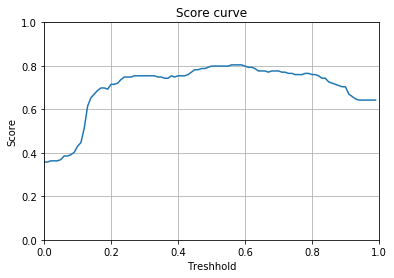

In [28]:
# Plot for treshhold of predicted probalities
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score

#prepare ylabel
ylabel = []
xlabel = []
for x in range(100):
    x /= 100
    y_pred_class = binarize([y_pred_prob], x)[0]
    ylabel.append(accuracy_score(y_test, y_pred_class))
    xlabel.append(x)

# Plot
plt.plot(xlabel, ylabel)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Score curve')
plt.xlabel('Treshhold')
plt.ylabel('Score')
plt.grid(True)


In [29]:
# Find threshhold for the highest score
def whereThreshold(X, y):
    y_pred_prob = logreg.predict_proba(X)[:,1]
    y_pred_class = binarize([y_pred_prob], 0.001)[0]
    highest = accuracy_score(y_test, y_pred_class)
    for i in range(1000):
        i /= 1000
        y_pred_class = binarize([y_pred_prob], i)[0]
        temporary = accuracy_score(y_test, y_pred_class)
        if highest < temporary:
            highest = temporary
            threshold = i
    return (highest, threshold)

In [30]:
print(whereThreshold(X_test, y_test))

(0.8044692737430168, 0.557)
